# Jane Street: 🔥Transformer🔥 Baseline

Transformer is very popular among time-series competitions. This notebook provides the training and inference pipelines for transformer encoder implementation. Due to the long training time, I only test a small model with small window size for inference (e.g., window size equals to 5). You may get better results by tuning the structure and hyperparameters as well as the window size.

In the latest version, I use numpy sliding-window function to create training samples instead of TensorFlow Dataset. It makes training faster but more memory consuming.

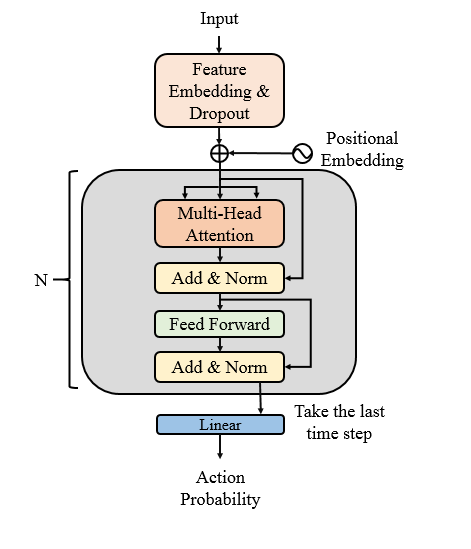

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.random.set_seed(42)
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

device = 'GPU' if 'GPU' in tf.test.gpu_device_name() else 'CPU/TPU'
print('Device:', device)

import os, gc, random, datetime
if device == 'GPU':
    import cudf
    import cupy as cp
import pandas as pd
import numpy as np
import janestreet
import xgboost as xgb
import datatable as dtable
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from joblib import dump, load
from time import time
from numba import njit

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [ ]:
MIXED_PRECISION = False
XLA_ACCELERATE = True

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

# Preprocessing

In [ ]:
%%time

print('Loading...')
train = dtable.fread('../input/jane-street-market-prediction/train.csv').to_pandas()
features = [c for c in train.columns if 'feature' in c]

print('Filling...')
train = train.query('weight > 0').reset_index(drop = True)
train[features] = train[features].fillna(method = 'ffill').fillna(0)
train['action'] = (train['resp'] > 0).astype('int')

print('Finish.')

# Training

Base Transformer structure from https://www.tensorflow.org/tutorials/text/transformer, modified with Swish activation function.

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b = True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis = -1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads):
        
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm = [0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm = [0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
    
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation = 'swish'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

class EncoderLayer(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, dff, rate = 0.1):
        
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training = training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training = training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

class TransformerEncoder(tf.keras.layers.Layer):
    
    def __init__(self, num_layers, d_model, num_heads, dff, 
                 maximum_position_encoding, rate = 0.1):
        
        super(TransformerEncoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dff = dff
        self.maximum_position_encoding = maximum_position_encoding
        self.rate = rate

#         self.pos_encoding = positional_encoding(self.maximum_position_encoding, 
#                                                 self.d_model)
#         self.embedding = tf.keras.layers.Dense(self.d_model)
        self.pos_emb = tf.keras.layers.Embedding(input_dim = self.maximum_position_encoding, 
                                                 output_dim = self.d_model)

        self.enc_layers = [EncoderLayer(self.d_model, self.num_heads, self.dff, self.rate) 
                           for _ in range(self.num_layers)]

        self.dropout = tf.keras.layers.Dropout(self.rate)
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'maximum_position_encoding': self.maximum_position_encoding,
            'dropout': self.dropout,
        })
        return config

    def call(self, x, training, mask = None):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
#         x += self.pos_encoding[:, :seq_len, :]
#         x = self.embedding(x)
        positions = tf.range(start = 0, limit = seq_len, delta = 1)
        x += self.pos_emb(positions)

        x = self.dropout(x, training = training)

        for i in range(self.num_layers):

            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [ ]:
def create_transformer_model(num_columns, num_labels, num_layers, d_model, num_heads, dff, window_size, dropout_rate, weight_decay, label_smoothing, learning_rate):
    
    inp = tf.keras.layers.Input(shape = (window_size, num_columns))
    x = tf.keras.layers.BatchNormalization()(inp)
    x = tf.keras.layers.Dense(d_model)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)
    x = tf.keras.layers.SpatialDropout1D(dropout_rate)(x)
    x = TransformerEncoder(num_layers, d_model, num_heads, dff, window_size, dropout_rate)(x)
    out = tf.keras.layers.Dense(num_labels, activation = 'sigmoid')(x[:, -1, :])
    
    model = tf.keras.models.Model(inputs = inp, outputs = out)
    model.compile(optimizer = tfa.optimizers.AdamW(weight_decay = weight_decay, learning_rate = learning_rate),
                  loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = label_smoothing), 
                  metrics = tf.keras.metrics.AUC(name = 'AUC'), 
                 )
    
    return model

These are some configurations. I use a small model for inference test.

In [ ]:
batch_size = 4096 * strategy.num_replicas_in_sync
num_layers = 1
d_model = 96
num_heads = 1
dff = 64
window_size = 3
dropout_rate = 0.15
weight_decay = 0
label_smoothing = 1e-2
learning_rate = 1e-3 * strategy.num_replicas_in_sync
verbose = 1

In [ ]:
with strategy.scope():
    model = create_transformer_model(len(features), 1, num_layers, d_model, num_heads, dff, window_size, dropout_rate, weight_decay, label_smoothing, learning_rate)
model.summary()

K.clear_session()
del model
rubbish = gc.collect()

In [ ]:
# Use Tensorflow Dataset
def prepare_dataset(X, y, window_size, batch_size, mode = 'training'):
    x_ds = tf.data.Dataset.from_tensor_slices(X) 
    y_ds = tf.data.Dataset.from_tensor_slices(y[window_size - 1:])
    x_ds = x_ds.window(window_size, shift = 1, drop_remainder = True)
    x_ds = x_ds.flat_map(lambda window: window.batch(window_size))
    dataset = tf.data.Dataset.zip((x_ds, y_ds))
    if mode == 'training':
        buffer_size = batch_size * 8
        dataset = dataset.repeat()
        dataset = dataset.shuffle(buffer_size, reshuffle_each_iteration = True)
        dataset = dataset.batch(batch_size)#, drop_remainder = True
    elif mode == 'validation':
        dataset = dataset.batch(batch_size)
        dataset = dataset.cache() 
    elif mode == 'testing':
        dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO)
    return dataset

# Use Numpy [may cause Out-of-Memory (OOM) error]
def rolling_window(a, shape):  # rolling window for 2D array
    s = (a.shape[0] - shape[0] + 1,) + (a.shape[1] - shape[1] + 1,) + shape
    strides = a.strides + a.strides
    return np.squeeze(np.lib.stride_tricks.as_strided(a, shape = s, strides = strides), axis = 1)

# Train-Test-Split Training

Split the train set into three folds, i.e., training-1, training-2 and validation sets. First, train the more on training-1 set and validate it on the validation set. Then use the training-2 set to find the best number of finetuning epochs. Finally, finetune on both training-2 and validation sets and submit.

In [ ]:
X_tr = train.loc[train['date'] < 303, features].values
y_tr = train.loc[train['date'] < 303, 'action'].values

X_tr2 = train.loc[(train['date'] >= 303) & (train['date'] <= 367), features].values
y_tr2 = train.loc[(train['date'] >= 303) & (train['date'] <= 367), 'action'].values

X_val = train.loc[train['date'] > 367, features].values
y_val = train.loc[train['date'] > 367, 'action'].values

rubbish = gc.collect()

In [ ]:
X_tr = rolling_window(X_tr, (window_size, len(features)))
X_val = rolling_window(X_val, (window_size, len(features)))
y_tr = y_tr[window_size - 1:]
y_val = y_val[window_size - 1:]
X_tr2 = rolling_window(X_tr2, (window_size, len(features)))
y_tr2 = y_tr2[window_size - 1:]

Train on the training-1 set and validate on the validation set.

In [ ]:
start_time_fold = time()

ckp_path = 'JSTransformer.hdf5'
with strategy.scope():
    model = create_transformer_model(len(features), 1, num_layers, d_model, num_heads, dff, window_size, dropout_rate, weight_decay, label_smoothing, learning_rate)
rlr = ReduceLROnPlateau(monitor = 'val_AUC', factor = 0.1, patience = 3, verbose = verbose, 
                        min_delta = 1e-4, mode = 'max')
ckp = ModelCheckpoint(ckp_path, monitor = 'val_AUC', verbose = 0, 
                      save_best_only = True, save_weights_only = True, mode = 'max')
es = EarlyStopping(monitor = 'val_AUC', min_delta = 1e-4, patience = 7, mode = 'max', 
                   baseline = None, restore_best_weights = True, verbose = 0)
history = model.fit(X_tr, y_tr, validation_data = (X_val, y_val), batch_size = batch_size,
                    epochs = 1000, callbacks = [rlr, ckp, es], verbose = verbose)
hist = pd.DataFrame(history.history)
print(f'[{str(datetime.timedelta(seconds = time() - start_time_fold))[0:7]}] ROC AUC:\t', hist['val_AUC'].max())

K.clear_session()
del model, X_tr, y_tr
rubbish = gc.collect()

Check the best number of epochs for finetuning.

In [ ]:
start_time_fold = time()

with strategy.scope():
    model = create_transformer_model(len(features), 1, num_layers, d_model, num_heads, dff, 
                                     window_size, dropout_rate, weight_decay, label_smoothing, 
                                     learning_rate / 100)
model.load_weights(ckp_path)
es = EarlyStopping(monitor = 'val_AUC', min_delta = 1e-4, patience = 7, mode = 'max', 
                   baseline = None, restore_best_weights = True, verbose = 0)
history2 = model.fit(X_tr2, y_tr2, validation_data = (X_val, y_val), batch_size = batch_size,
                    epochs = 1000, callbacks = [es], verbose = verbose)
hist2 = pd.DataFrame(history2.history)
print(f'[{str(datetime.timedelta(seconds = time() - start_time_fold))[0:7]}] ROC AUC:\t', hist2['val_AUC'].max())
finetune_epochs = hist2['val_AUC'].argmax() + 1

K.clear_session()
del model
rubbish = gc.collect()

Train on both training-2 and validation sets.

In [ ]:
with strategy.scope():
    model = create_transformer_model(len(features), 1, num_layers, d_model, num_heads, dff, 
                                     window_size, dropout_rate, weight_decay, label_smoothing, 
                                     learning_rate / 100)
model.load_weights(ckp_path)
model.fit(np.concatenate((X_tr2, X_val)), np.concatenate((y_tr2, y_val)), 
          batch_size = batch_size,epochs = finetune_epochs, verbose = verbose)
model.save_weights(ckp_path)

K.clear_session()
del model, X_tr2, y_tr2, X_val, y_val
rubbish = gc.collect()

# GroupCV Training

In [ ]:
# gkf = GroupKFold(n_splits = 5)
# for fold, (tr, te) in enumerate(gkf.split(train['action'].values, train['action'].values, train['date'].values)):
    
#     start_time_fold = time()
#     X_tr, X_val = train.loc[tr, features].values, train.loc[te, features].values
#     y_tr, y_val = train.loc[tr, 'action'].values, train.loc[te, 'action'].values
    
#     train_steps = int((X_tr.shape[0] // batch_size) + 1)
#     val_steps = int((X_val.shape[0] // batch_size) + 1)
    
#     dataset_tr = prepare_dataset(X_tr, y_tr, window_size, batch_size, 'training')
#     dataset_val = prepare_dataset(X_val, y_val, window_size, batch_size, 'validation')
    
#     ckp_path = f'JSModel_{fold}.hdf5'
#     with strategy.scope():
#         model = create_transformer_model(len(features), 1, num_layers, d_model, num_heads, dff, window_size, dropout_rate, weight_decay, label_smoothing, learning_rate)
#     rlr = ReduceLROnPlateau(monitor = 'val_AUC', factor = 0.1, patience = 3, verbose = verbose, 
#                             min_delta = 1e-4, mode = 'max')
#     ckp = ModelCheckpoint(ckp_path, monitor = 'val_AUC', verbose = 0, 
#                           save_best_only = True, save_weights_only = True, mode = 'max')
#     es = EarlyStopping(monitor = 'val_AUC', min_delta = 1e-4, patience = 7, mode = 'max', 
#                        baseline = None, restore_best_weights = True, verbose = 0)
#     history = model.fit(dataset_tr, steps_per_epoch = train_steps, 
#                         validation_data = dataset_val, validation_steps = val_steps, 
#                         epochs = 1000, callbacks = [rlr, ckp, es], verbose = verbose)
#     hist = pd.DataFrame(history.history)
    
#     K.clear_session()
#     del model
#     rubbish = gc.collect()
    
#     # Finetune 3 epochs on validation set with small learning rate
#     with strategy.scope():
#         model = create_transformer_model(len(features), 1, num_layers, d_model, num_heads, dff, window_size, dropout_rate, weight_decay, label_smoothing, learning_rate / 100)
#     model.load_weights(ckp_path)
#     dataset_val = prepare_dataset(X_val, y_val, window_size, batch_size, 'training')
#     model.fit(dataset_val, steps_per_epoch = val_steps, epochs = 3, verbose = 0)
#     model.save_weights(ckp_path)
    
#     print(f'[{str(datetime.timedelta(seconds = time() - start_time_fold))[0:7]}] Fold {fold} ROC AUC:\t', hist['val_AUC'].max())
    
#     K.clear_session()
#     del model, X_tr, X_val, y_tr, y_val, dataset_tr, dataset_val
#     rubbish = gc.collect()
#     break

# Load Model

In [ ]:
with strategy.scope():
    model = create_transformer_model(len(features), 1, num_layers, d_model, num_heads, dff, window_size, dropout_rate, weight_decay, label_smoothing, learning_rate)
model.load_weights('./JSTransformer.hdf5')

# Submitting

In [ ]:
# https://www.kaggle.com/gogo827jz/optimise-speed-of-filling-nan-function
@njit
def fast_fillna(array, values):
    if np.isnan(array.sum()):
        array = np.where(np.isnan(array), values, array)
    return array

# The first run of numba decorated function requires compiling, which takes longer time than the later runs. So, we compile it before submission.
train.loc[0, features[1:]] = fast_fillna(train.loc[0, features[1:]].values, 0)

In [ ]:
env = janestreet.make_env()
env_iter = env.iter_test()

In [ ]:
opt_th = 0.505
tmp = np.zeros((1, window_size, len(features)))
for (test_df, pred_df) in tqdm(env_iter):
    if test_df['weight'].item() > 0:
        x_tt = test_df.loc[:, features].values
        x_tt[0] = fast_fillna(x_tt[0], tmp[0, -1])
        tmp[0] = np.concatenate((tmp[0, 1:], x_tt))
        pred = model(tmp, training = False).numpy().item()
        pred_df.action = np.where(pred >= opt_th, 1, 0).astype(int)
    else:
        pred_df.action = 0
    env.predict(pred_df)